In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import json
import glob
import cv2
import imageio
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from modules.ShapeNetHandler import ShapeNetHandler as ShapeNetSourceHandler
import matplotlib.pyplot as plt
import modules.utils

from IPython.display import Image, display

# Device

In [17]:
!nvidia-smi

Thu Mar 12 04:36:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:05:00.0 Off |                  N/A |
| 38%   66C    P2   101W / 250W |   3392MiB / 12194MiB |     38%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   44C    P8    10W / 250W |  12163MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [18]:
GPU_ON = True
GPU_num = 0
RANDOM_SEED = 42
DEVICE = torch.device(f"cuda:{GPU_num}" if torch.cuda.is_available() and GPU_ON else 'cpu')

# Utils.set_seed(RANDOM_SEED)
print(f"Device: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")

Device: cuda:0
Random seed: 42
Device: cuda:0
Random seed: 42


# Pretrained Model

In [19]:
# Source: https://pytorch.org/docs/stable/torchvision/models.html
resnet18 = models.resnet18(pretrained=True).to(DEVICE)
# inception = models.inception_v3(pretrained=True)

In [20]:
imagenet_labels_root = "imagenet_class_index.json"
imagenet_idx2label = modules.utils.load_imagenet_labels(imagenet_labels_root)

# Dataset Handler
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [46]:
class ShapeNetData(Dataset):
    def __init__(self, root, resize=True, dim=256, transforms=None):
        super().__init__()
        self.root = root
        self.resize = resize
        self.dim = dim
        self.transforms = transforms
        
        self._setup_paths()
    
    def _get_path_info(self, path):
        class_id = path.split(os.path.sep)[-3]
        if 'synset' in class_id.lower():
            class_id = int(class_id.split("_")[1])
        instance_id = path.split(os.path.sep)[-2]
        return class_id, instance_id
    
    def _setup_paths(self):
        print(f"Building image filepaths from {self.root}...")        
        self.filepaths = glob.glob(f'{self.root}/*/*')
        print("Path setup complete.")
        
    def __len__(self):
        return len(self.filepaths)

    def _load_img(self, path):
        img = imageio.imread(path)
        if self.resize:
            img = cv2.resize(img, (self.dim, self.dim))
        return img
    
    def __getitem__(self, idx):
        # Get path
        path_i = self.filepaths[idx]
        
        # Image
        img = modules.utils.read_image(path_i, parse_mask=False)
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, path_i

In [47]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [48]:
# Source: https://pytorch.org/docs/stable/torchvision/models.html
# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
# where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and 
# then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
# You can use the following transform to normalize:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
fixed_normalize_transform = torchvision.transforms.Normalize(mean=mean, std=std)
fixed_unnormalize_transform = UnNormalize(mean=mean, std=std)

In [49]:
_ROOT = '/hdd/mliuzzolino/Places2/places365_standard/train'
_BATCH_SIZE = 128

In [50]:
transformations = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    fixed_normalize_transform
])

In [51]:
dataset = ShapeNetData(root=_ROOT, transforms=transformations)
datahandler = DataLoader(dataset, batch_size=_BATCH_SIZE, shuffle=True)

Building image filepaths from /hdd/mliuzzolino/Places2/places365_standard/train...
Building image filepaths from /hdd/mliuzzolino/Places2/places365_standard/train...
Path setup complete.
Path setup complete.


### Preview Images

(-0.5, 2065.5, 4129.5, -0.5)

(-0.5, 2065.5, 4129.5, -0.5)

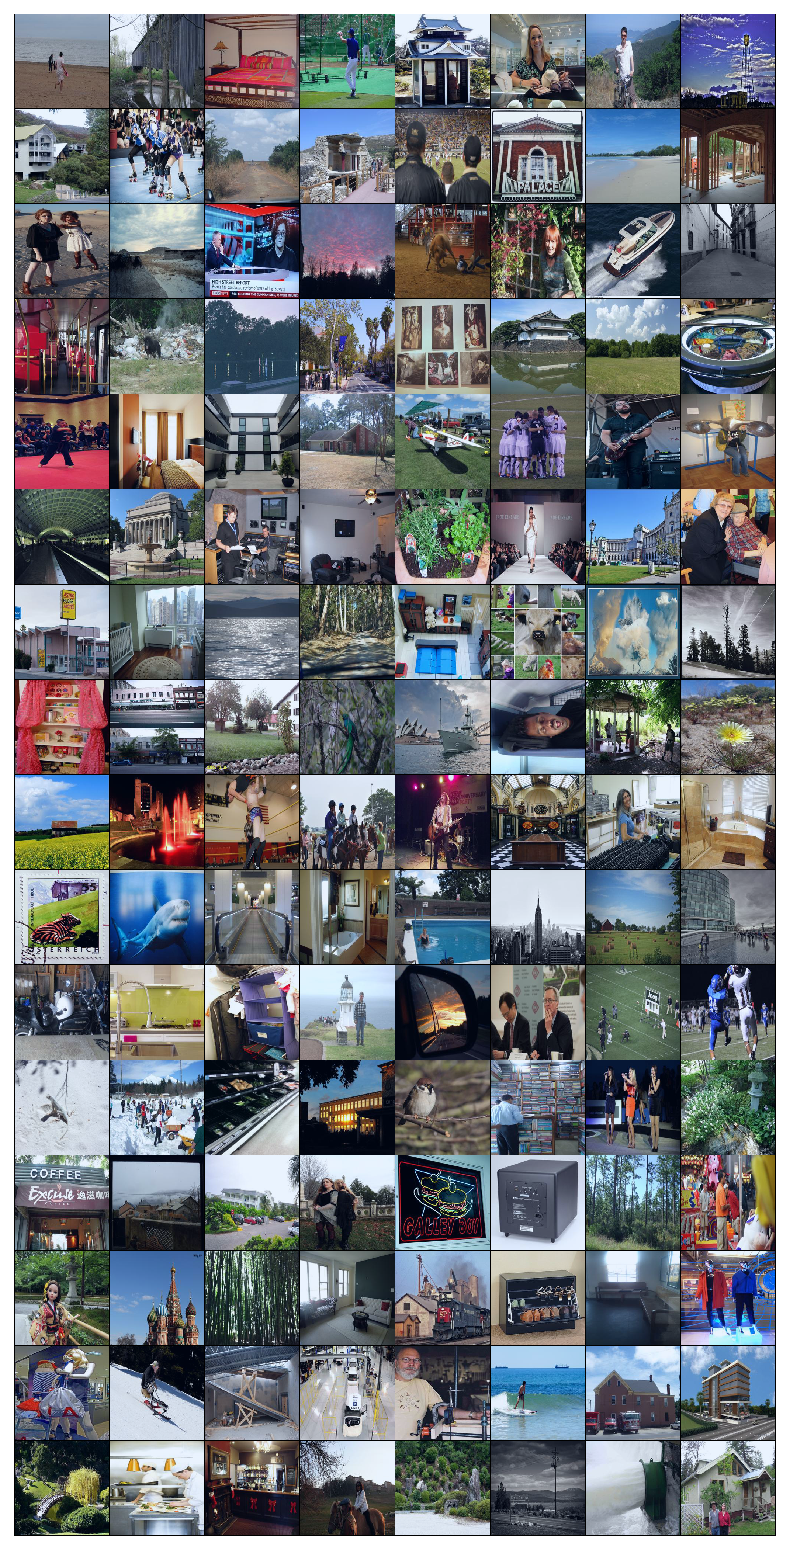

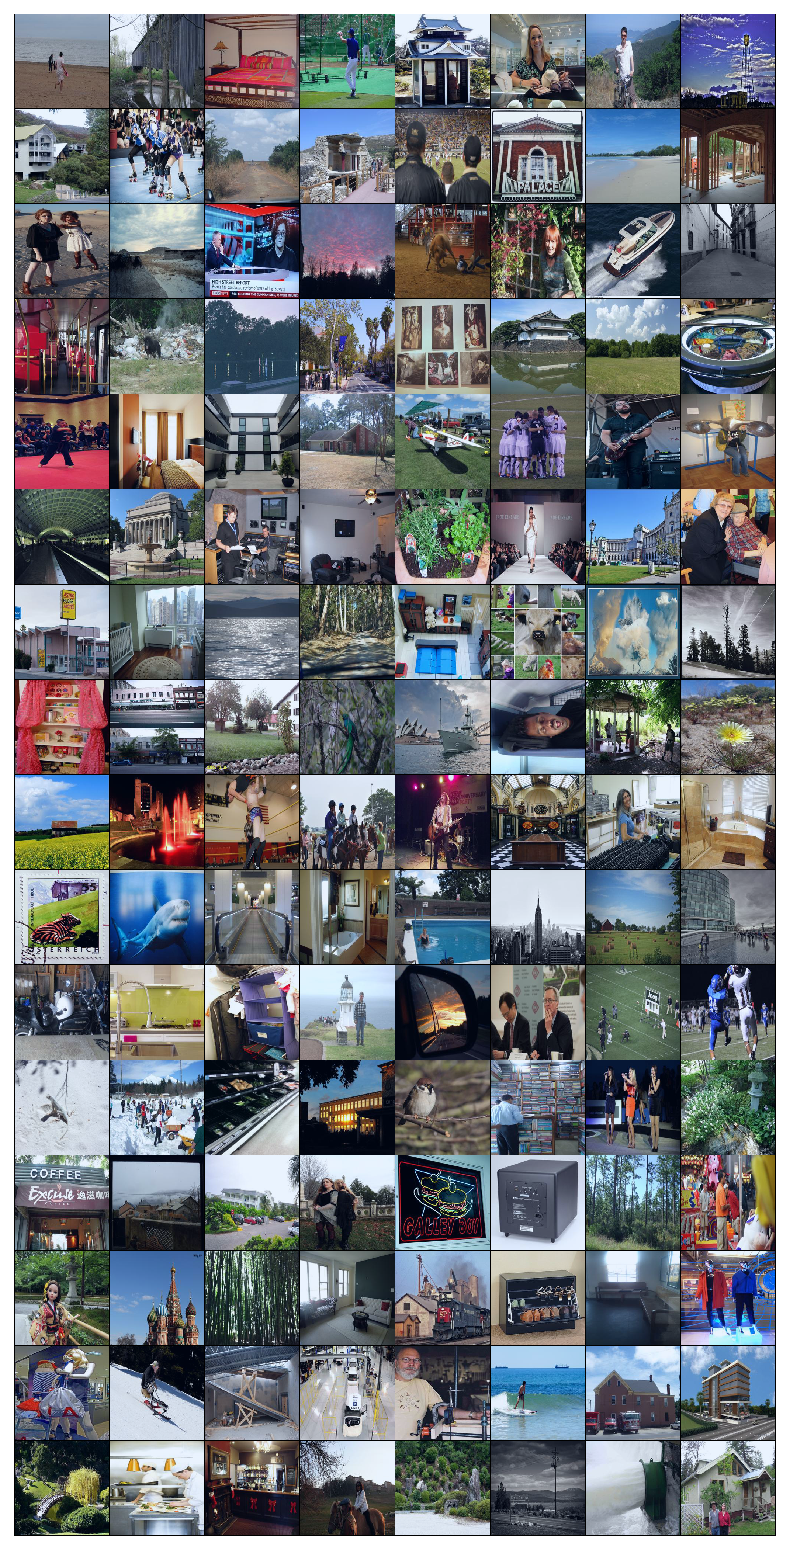

In [52]:
for i, (imgs, img_paths) in enumerate(datahandler):
    break
grid_imgs = torchvision.utils.make_grid(imgs, normalize=True).permute(1,2,0)
plt.figure(figsize=(14,14))
plt.imshow(grid_imgs)
plt.axis('off')

# Evaluate

In [53]:
get_prediction_idxs = lambda out : torch.argmax(nn.Softmax(dim=1)(out), dim=1)

In [54]:
EVAL_BATCH_LIMIT = 2
BAD_MATCH_LABEL = len(imagenet_idx2label)+1

In [55]:
all_predictions = []
try:
    for i, (imgs, img_paths) in enumerate(datahandler):
        
        if i > EVAL_BATCH_LIMIT:
            break
        sys.stdout.write(f"\rEvaluating {i+1}/{len(datahandler)}...")
        sys.stdout.flush()

        # Send to device
        imgs = imgs.to(DEVICE)

        # Inference
        output = resnet18(imgs)
        predicted_labels = get_prediction_idxs(output).cpu()
        predictions = [(pred_idx.item(), imagenet_idx2label[pred_idx], img_paths[j]) 
                           for j, pred_idx in enumerate(predicted_labels)]
    
        all_predictions += predictions
        
except KeyboardInterrupt:
    print("\nEnding Early")

Evaluating 36/14090...
Ending Early

Ending Early


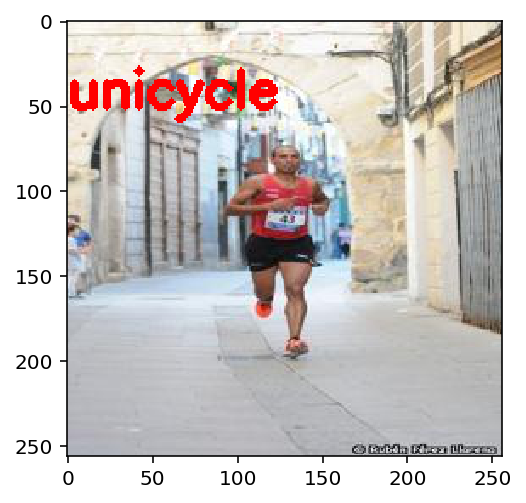

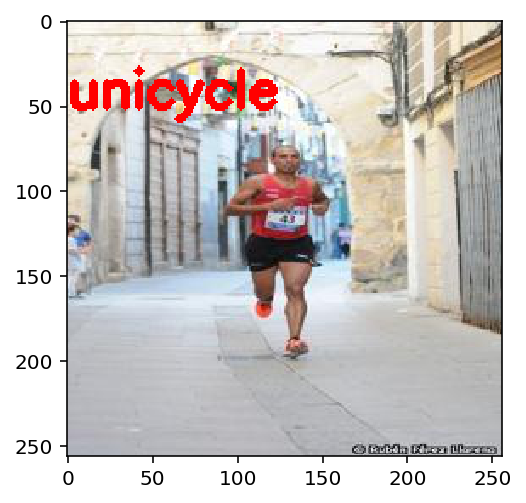

In [62]:
rand_i = np.random.choice(range(len(all_predictions)))
pred_idx, pred_name, pred_path = all_predictions[rand_i]
img = modules.utils.read_image(pred_path, parse_mask=False)
annotated_im = modules.utils.add_labels_to_img(img, pred_name, fontsize=1, x=0, y=50, text_color=[255,0,0])
plt.imshow(annotated_im)

# Visualize

In [31]:
_VIS_LIMIT = 100
random_idxs = np.random.choice(range(all_imgs.shape[0]), _VIS_LIMIT, replace=False)
for i, idx in enumerate(random_idxs):
    img = all_imgs[idx]
    label = all_predicted_labels[idx]
    if i > _VIS_LIMIT:
        break
    img = (fixed_unnormalize_transform(img.clone()) * 255).byte()
    img_np = img.permute(1,2,0).cpu().numpy()
    annotated_im = modules.utils.add_labels_to_img(img_np, label, fontsize=1, x=0, y=50, text_color=[255,0,0])
    annotated_im = annotated_im[np.newaxis,...]
    if i == 0:
        all_annotated_images = annotated_im
    else:
        all_annotated_images = np.concatenate([all_annotated_images, annotated_im], axis=0)

NameError: name 'all_imgs' is not defined

NameError: name 'all_imgs' is not defined

In [ ]:
all_annotated_images_pt = torch.tensor(all_annotated_images).permute(0,3,1,2)
all_annotated_grid = torchvision.utils.make_grid(all_annotated_images_pt, nrow=10).permute(1,2,0)

In [ ]:
plt.figure(figsize=(14,14))
plt.imshow(all_annotated_grid)
plt.axis('off')
plt.savefig('Resnet18_examples.png', dpi=250)